In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report


# CRISP
## Business understanding:
- The first phase is to understand the business problem that needs to be solved.
- What is the goal of the analysis?
- What are the requirements and constraints? What is the expected outcome?

## Data understanding:
 - The second phase is to collect and explore the data.
 - What data is available?
 - What are the characteristics of the data (variable types, value distributions etc.)?
 - Are there any quality issues with the data (missing values, outliers, nonsensical values)?

## Data preparation:
 - The third phase is to preprocess the data.
 - This includes cleaning the data, transforming the data, and selecting the relevant features.
 - These steps should be documented in such detail that they can be reproduced later.

## Modeling:
 - The fourth phase is to choose a machine learning method and train the model.
 - This phase also includes the validation of the model.
 - Documentation needs include:
   - which method was used, which parameters were used, what was the performance of the model?

## Evaluation:
 - The fifth phase is to evaluate the model.
 - How well does the model perform?
 - Does it meet the business requirements?

## Deployment:
 - The final phase is to deploy the model.
 - How will the model be used in practice?
 - How will the results be communicated?
 - This phase may involve creating a recommendation of how to use the model in practice, or what to do next.


## Phase 1: Business Understanding
- The goal is to reliably predict if website is a phishing site based on the information about the site using UCI Machine Learning Repository: Phishing Websites Data Set.

## Phase 2: Data understanding


In [11]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
phishing_websites = fetch_ucirepo(id=327)

# data (as pandas dataframes)
X = phishing_websites.data.features
y = phishing_websites.data.targets

print(phishing_websites.variables.name)

0              having_ip_address
1                     url_length
2             shortining_service
3               having_at_symbol
4       double_slash_redirecting
5                  prefix_suffix
6              having_sub_domain
7                 sslfinal_state
8     domain_registration_length
9                        favicon
10                          port
11                   https_token
12                   request_url
13                 url_of_anchor
14                 links_in_tags
15                           sfh
16           submitting_to_email
17                  abnormal_url
18                      redirect
19                  on_mouseover
20                    rightclick
21                   popupwindow
22                        iframe
23                 age_of_domain
24                     dnsrecord
25                   web_traffic
26                     page_rank
27                  google_index
28        links_pointing_to_page
29            statistical_report
30        

## Phase 3: Data Preparation

The third phase is to preprocess the data. We remove missing values and transform categorical variables into numeric form to make the dataset ready for machine learning models.

By removing missing values to ensures that we work only with complete data.

By selecting relevant features, we improve model performance, reduce overfitting, and make the model easier to interpret.


 By selecting relevant features, we improve model performance, reduce overfitting, and make the model easier to interpret.

### Steps 

#### Removing Missing Values:

Using `dropna()` from Pandas. This ensures that we work only with complete data.

In [12]:
# Data Cleaning
# - Remove missing values to ensure data consistency
X = X.dropna()  # Remove rows with missing values


Transforming Target Column (`y`): use the `replace()` method in Pandas to replace `-1` with `0` and leave `1` unchanged.

In [13]:
# Convert 'result' column to numeric: 0 = Legal, 1 = Phishing site
y = y.replace({-1: 0, 1: 1})  # Replace -1 with 0 and 1 remains as 1

#### Feature Selection:

We choose features based on what we know about the field or how important each feature is for predicting the target variable.

Using the selected feature list, we create a new dataframe with only these columns.

In [14]:
# Select important features
selected_features = [
    'url_length', 'shortining_service', 'having_at_symbol', 'double_slash_redirecting', 
    'prefix_suffix', 'having_sub_domain', 'sslfinal_state', 'abnormal_url', 'https_token', 'redirect', 'url_of_anchor', 'iframe', 'request_url', 'submitting_to_email'
]

#### Plitting the Data:

 To evaluate the model's performance on unseen data, we split the data into two subsets: 
    - Training data (80%) for training the model.
    - Test data (20%) for evaluating how well the model generalizes to new data.
    
  We use `train_test_split()` from scikit-learn to divide the data into training and test sets. 

In [15]:
# Create X with only selected features
X_selected = X[selected_features]

# Data Splitting
# Split the data: 80% training data, 20% testing data
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Check the split sizes to ensure it's correct
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8844, 14) (2211, 14) (8844, 1) (2211, 1)


We use `head()` to print the first few rows of the selected features dataset. Make sure everything looks correct before moving on to training.

In [29]:
print(X_selected.head())  # Print first few rows of the selected features dataset
feature_names = X_selected.columns.tolist()


   url_length  shortining_service  having_at_symbol  double_slash_redirecting  \
0           1                   1                 1                        -1   
1           1                   1                 1                         1   
2           0                   1                 1                         1   
3           0                   1                 1                         1   
4           0                  -1                 1                         1   

   prefix_suffix  having_sub_domain  sslfinal_state  abnormal_url  \
0             -1                 -1              -1            -1   
1             -1                  0               1             1   
2             -1                 -1              -1            -1   
3             -1                 -1              -1             1   
4             -1                  1               1             1   

   https_token  redirect  url_of_anchor  iframe  request_url  \
0           -1         0          

## Phase 4: Modeling
### PART 1
The chosen method is Decision Tree Classifier sklearn.tree.
model = DecisionTreeClassifier(max_depth=4, random_state=42)
- max_depth=4: Limits the depth of the tree to 4 levels to prevent overfitting.
- random_state=42: Ensures reproducibility of the results by setting a seed for the random number generator. Number 42 was chosen because everyone knows that 42 is the answer to the ultimate question of life, the universe, and everything.

model.fit(X_train, y_train)
The model is trained using the training data X_train and y_train.

plt.figure(figsize=(20,10))
plot_tree(model, feature_names=X_selected.columns, class_names=['Legit', 'Phishing'], filled=True)
plt.show()
- A visual representation of the decision tree is created using plot_tree.
- feature_names=X_selected.columns: Names of the features used in the model.
- class_names=['Legit', 'Phishing']: Names of the target classes.
- filled=True: Colors the nodes to indicate the majority class.

y_pred = model.predict(X_test)
- Predictions are made on the test data X_test.

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
- accuracy_score: Measures the overall accuracy of the model.
- confusion_matrix: Provides a summary of prediction results.
- precision_score: Measures the precision of the model.
- recall_score: Measures the recall of the model.

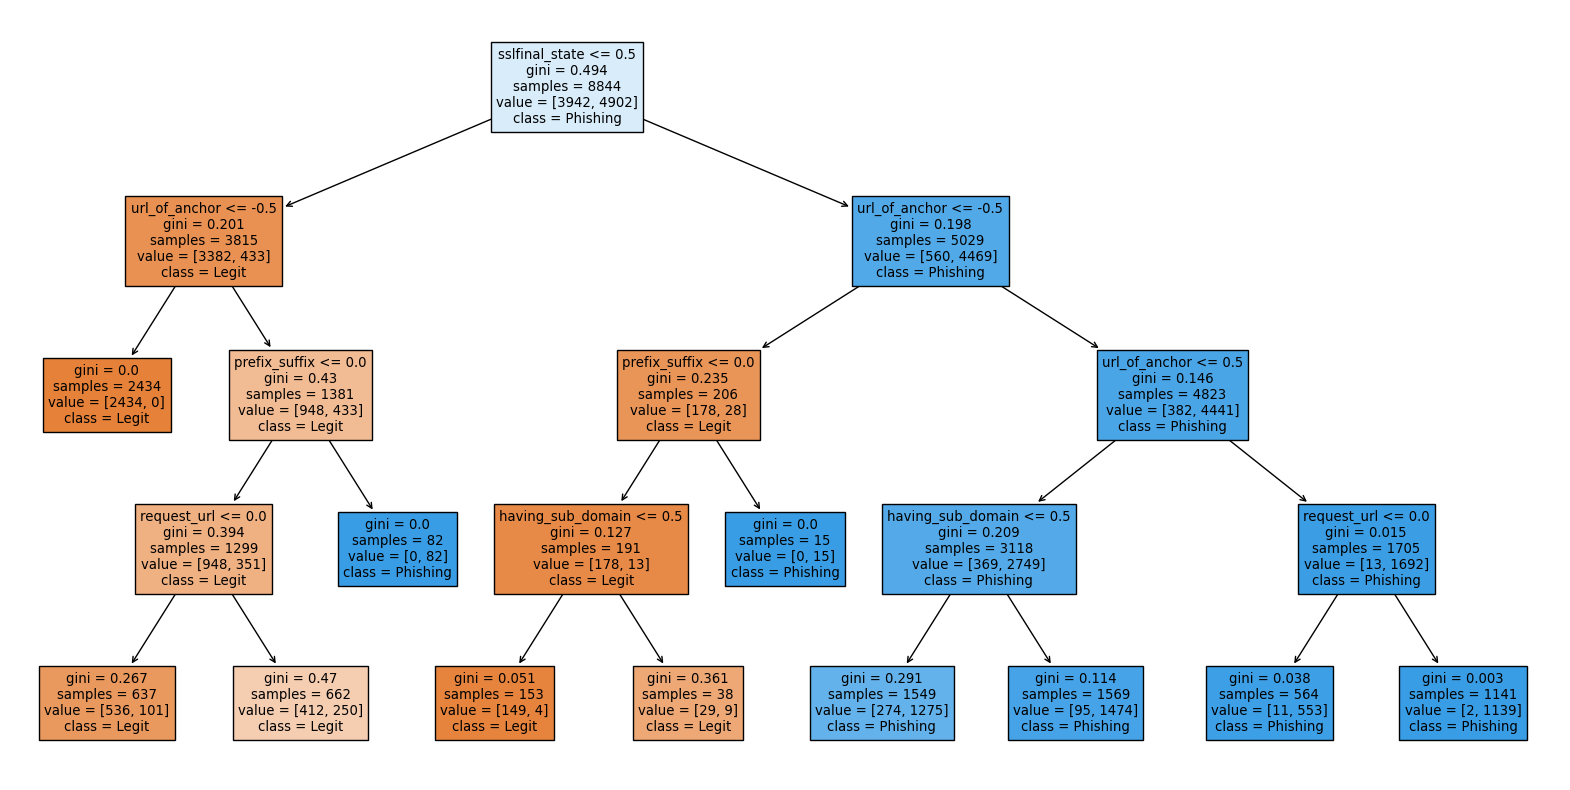

Accuracy: 0.9231117141564903
Confusion Matrix:
[[ 865   91]
 [  79 1176]]


In [30]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Phase 4: Modeling
# Choose machine learning method and train the model. This phase also includes the validation of the model.

# Train a decision tree model
model = DecisionTreeClassifier(max_depth=4,random_state=42)
model.fit(X_train, y_train)

# Visualize the decision tree
plt.figure(figsize=(20,10))
plot_tree(model, feature_names=feature_names, class_names=['Legit', 'Phishing'], filled=True)
plt.show()

# Evaluate the decision tree
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')

### PART 2

We use the sklearn.ensemble classifier to produce our Random Forest Classifier.
model = RandomForestClassifier(random_state = 42, n_estimators = 100, max_features=0.8, max_samples=0.7)
- random_state = Like in desision tree, here too this ensures reproducibility. Every time you run this code with the same data, you'll get the same results because it fixes the randomness used in the model training.
- n_estimators=100 = The number of "trees" in the "forest". We are creating mutlible trees that each make their own predictions.
- max_features=0.8 =


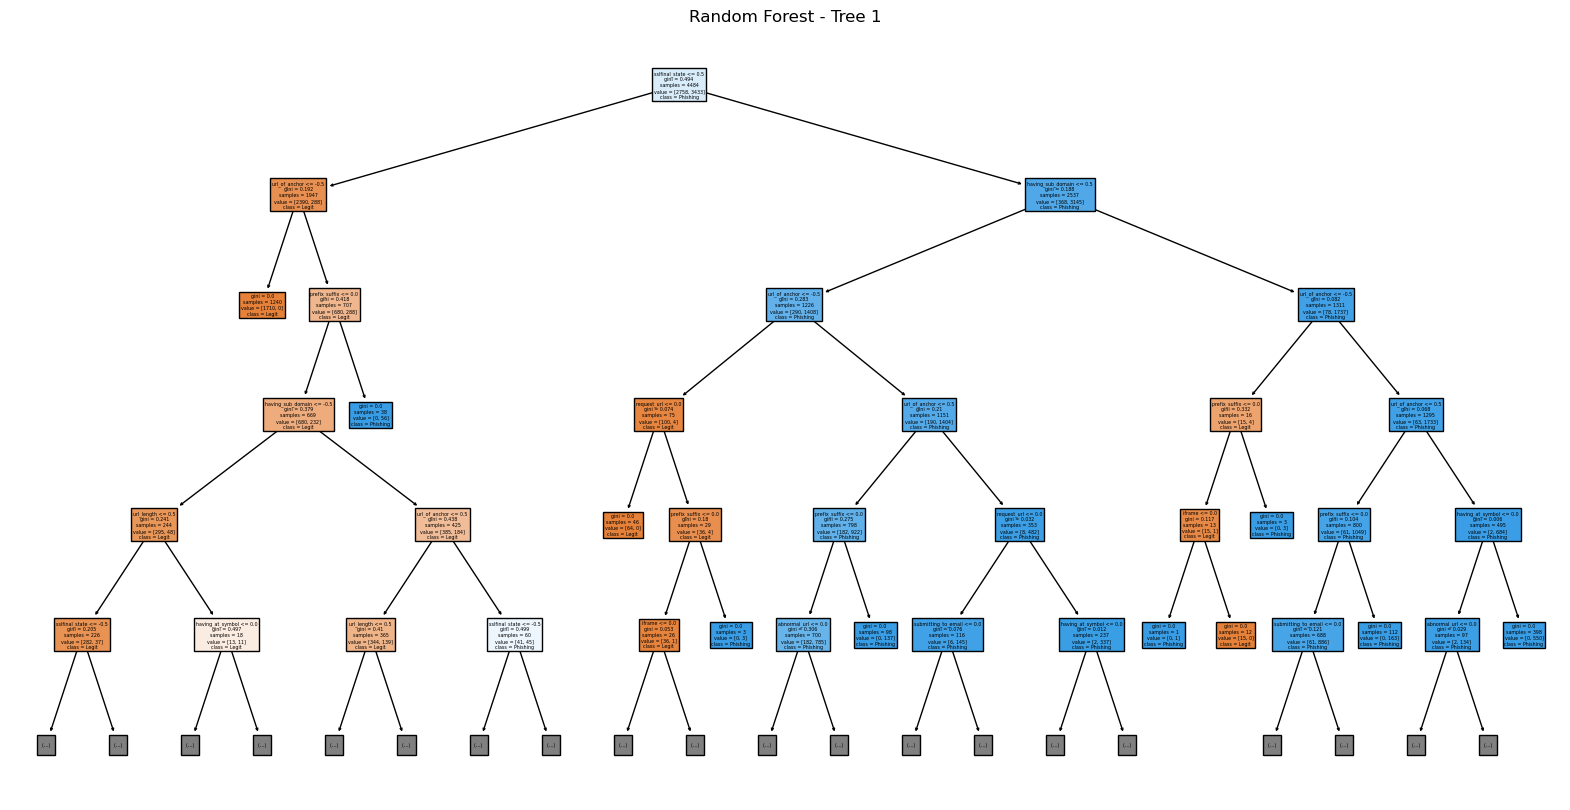

Accuracy: 0.9380370872908186
Confusion Matrix:
[[ 865   91]
 [  46 1209]]


In [54]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state = 42, n_estimators = 100, max_features=0.8, max_samples=0.7, max_depth=10)
model.fit(X_train, y_train.values.ravel())

plt.figure(figsize=(20, 10))

plot_tree(model.estimators_[0], filled=True, feature_names=feature_names,
          class_names=['Legit', 'Phishing'], max_depth=5)

plt.title('Random Forest - Tree 1')
plt.show()

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')


In [209]:
# Phase 5: Evaluation
# Evaluate the model. How well does the model perform? Does it meet the business requirements?

In [210]:
# Phase 6: Deployment
# Deploy the model. How will the model be used in practice? How will the results be communicated?